In [107]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [109]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [111]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [304]:
block_size = 3 # ctx len
    
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

# train/dev/test split 80/10/10
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [333]:
g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, 10)) # 10d embedding space
W1 = torch.randn((3*10, 300)) # 300 neurons in hyper-param layer
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # param count

17697

In [334]:
for p in parameters:
    p.requires_grad = True
    
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [335]:
def train(lr):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (100,))

    # forward
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad

    return loss.item()

In [215]:
# find ideal update rate
lri = []
lossi = []
for i in range(1000):
    loss = train(lrs[i])
    
    # stats
    lri.append(lre[i])
    lossi.append(loss.item())

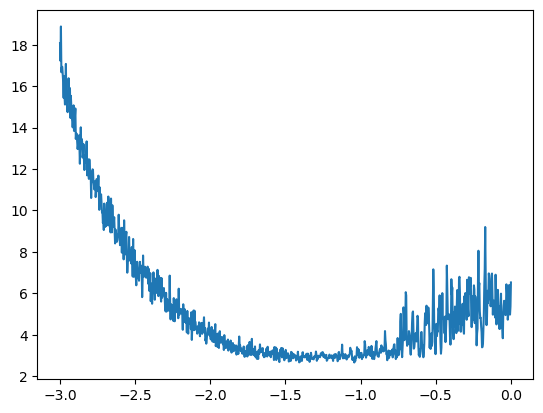

In [216]:
plt.plot(lri, lossi)

In [337]:
from tqdm.notebook import tqdm
import numpy as np

ideal_lr = 10 ** -1
for _ in tqdm(np.arange(10000)):
    train(ideal_lr)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [341]:
# learning rate decay, late-stage training
ideal_lr = 1000 ** -1
for _ in tqdm(np.arange(10000)):
    train(ideal_lr)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [342]:
def loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y).item()

print('Training: ', loss(Xtr, Ytr))
print('Dev: ', loss(Xdev, Ydev))
print('Test: ', loss(Xte, Yte))

Training:  2.3038594722747803
Dev:  2.322495698928833
Test:  2.316284656524658


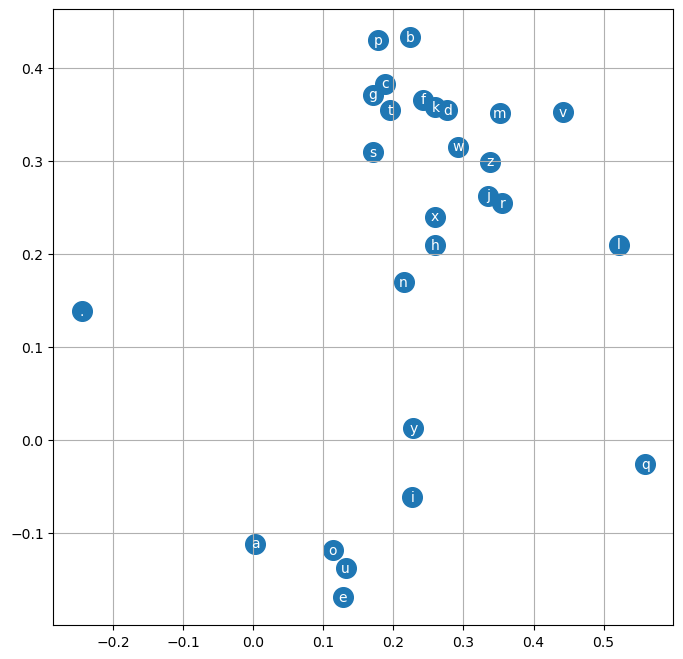

In [332]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [343]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
ami.
hari.
kimrix.
thty.
salayan.
jaronen.
dellyn.
jareei.
neronia.
chaiiv.
kaleig.
dham.
joce.
quinn.
sulin.
alian.
qui.
jerogijaryni.
jace.
